<a href="https://colab.research.google.com/github/MKolaksazov/Data-Science/blob/main/Colab%20code%20(graphs)/Tukey_test_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drawing a 'BOXPLOT' graph

Includes letters, showing the significant differences between variants, derived by the means of the Tukey's test.

####1) importing of the libraries and the **.csv** file

The columns of this table file should containt parameters, whereas the group variants written as indexes of the rows. These indexes will be shown in the first column, named *'groups'*.

the delimiter is usually a semicolon ```;```, but can be a tabulation ```\t```


In [44]:
import pandas as pd
import numpy as np
# exp_0726_OJIP_p
df = pd.read_csv("/content/CCI.csv", delimiter=';', decimal=',') # delimiter '\t' or ';'

1.2) Popping out the labels of the variation groups in a dataframe, called *'names'*.
Transposing the dataframe, so that it can be easily processed by the covariance test analysis and matplotlib. Converting it into numpy array.

In [45]:
names = df.pop('groups')
transposed_df = df.T
named = np.array(names)
transposed_df

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
cci,37.3,51.7,58.0,72.0,61.9,21.8,47.1,61.7,59.0,49.2,...,54.7,60.9,51.9,37.1,28.8,63.1,18.2,40.2,54.0,35.4


1.3) An optional step required to abbreviate the longer latin names of the crops, so that they can fit in the graph.

In [46]:
import re
# Abbreviating the latin names from 'Aaaaa aaaaaa (L.)' to 'A. aaaaaa (L.)'
for i in range(len(names)):
    c = names[i][0]
    names[i] = re.sub(r'[A-Z]([a-z]+ )', c + '. ', names[i])
names

0     MB
1     MB
2     MB
3     MB
4     MB
      ..
63    MR
64    MR
65    MR
66    MR
67    MR
Name: groups, Length: 68, dtype: object

1.4) Popping out the column with the desired parameter by writing the name in the 'pop' function, as well as transposing it.

In [47]:
params = df.pop('cci') #required param
transp_df = params.T

#dff = np.array(params)

1.5) Converting the dataframe into a 1D numpy array

In [49]:
from matplotlib.patches import namedtuple
#convert dataframe to matrix
conv_arr= transp_df.values

#split matrix into 3 columns each into 1d array

#converting into 1D array
one_D_array = conv_arr.ravel()

print(one_D_array)

# variants as well:
print(names)

[37.3 51.7 58.  72.  61.9 21.8 47.1 61.7 59.  49.2 64.4 50.  40.  47.1
 35.6 38.2 28.3 43.7 45.3 59.8 33.3 58.1 77.6 64.4 64.1 72.6 75.6 50.9
 71.6 70.2 53.1 69.4 47.  46.8 47.9 60.3 64.1 48.6 65.5 62.  48.6 60.7
 58.1 68.1 52.4 57.5 43.2 61.6 34.8 64.8 57.8 75.3 61.2 67.  41.  53.7
 57.5 73.3 54.7 60.9 51.9 37.1 28.8 63.1 18.2 40.2 54.  35.4]
0     MB
1     MB
2     MB
3     MB
4     MB
      ..
63    MR
64    MR
65    MR
66    MR
67    MR
Name: groups, Length: 68, dtype: object


####2) arranging the data by samples column-wise and taking out the names of the variants in a different array

Converting the 2-D pandas dataframe into a 1-D numpy array. ```numpy.append(array1, array2) ``` can be used to append two arrays.

Probably ```pandas.dataframe.pop()``` can be used as well.

In [50]:
# Sample data (replace this with your data)
data = pd.DataFrame({
    'Variant': names,
    'Value': one_D_array
})

3) performing the co-variance test
(the following is a variant, showing the t-test)
(currently not shown)

4) This is a very simple code, showing a Tukey's test analysis and printing the summarized data

In [51]:
import statsmodels.stats.multicomp as mc

# Perform one-way ANOVA to check for significant differences
model = mc.MultiComparison(data['Value'], data['Variant'])
result = model.tukeyhsd()

print(result.summary(), len(result.reject))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    B1     B2    24.01 0.0003   8.5359 39.4841   True
    B1     B3  11.5933 0.2986  -4.3048 27.4914  False
    B1    Ch1    12.89 0.1636  -2.5841 28.3641  False
    B1    Ch2  14.7236 0.0611  -0.3947 29.8419  False
    B1     MB   9.9017 0.4024  -4.9136  24.717  False
    B1     MR    -2.99 0.9986 -20.8579 14.8779  False
    B2     B3 -12.4167 0.2243 -28.3148  3.4814  False
    B2    Ch1   -11.12 0.3155 -26.5941  4.3541  False
    B2    Ch2  -9.2864 0.5058 -24.4047  5.8319  False
    B2     MB -14.1083 0.0719 -28.9236   0.707  False
    B2     MR    -27.0 0.0004 -44.8679 -9.1321   True
    B3    Ch1   1.2967    1.0 -14.6014 17.1948  False
    B3    Ch2   3.1303 0.9961 -12.4217 18.6823  False
    B3     MB  -1.6917 0.9999 -16.9493  13.566  False
    B3     MR -14.5833 0.2009 -32.8197  3.6531  False
   Ch1    Ch2   1.8336 0.999

In [52]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [53]:
# define columns for data and then grouping
col_to_group='Variant'
col_for_data='Value'

#Now take teh data and regroup for anova
samples = [cols[1] for cols in data.groupby('Variant')['Value']]
#I am not sure how this works but it makes an numpy array for each group
f_val, p_val = stats.f_oneway(*samples)
# I am not sure what this star does but this passes all the numpy arrays correctly

# this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
#if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
mod = mc.MultiComparison(data['Value'], data['Variant'])
thsd=mod.tukeyhsd()

#this is a function to do Piepho method.
#AN Alogrithm for a letter based representation of al-pairwise comparisons.
tot=len(thsd.groupsunique)
#make an empty dataframe that is a square matrix of size of the groups. #set first column to 1
df_ltr=pd.DataFrame(np.nan, index=np.arange(tot),columns=np.arange(tot))
#df_ltr.iloc[:,0]=1
df_ltr[df_ltr.columns[0]] = 1
#df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)

count=0
df_nms = pd.DataFrame('', index=np.arange(tot), columns=['names'])
# I make a dummy dataframe to put axis labels into.  sd stands for signifcant difference

for i in np.arange(tot):   #I loop through and make all pairwise comparisons.
    for j in np.arange(i+1,tot):
        #print('i=',i,'j=',j,thsd.reject[count])
        if thsd.reject[count]==True:
            for cn in np.arange(tot):
                if df_ltr.iloc[i,cn]==1 and df_ltr.iloc[j,cn]==1:
                  #If the column contains both i and j shift and duplicat
                    df_ltr=pd.concat([df_ltr.iloc[:,:cn+1],df_ltr.iloc[:,cn+1:].T.shift().T],axis=1)
                    df_ltr[df_ltr.columns[cn+1]]=df_ltr[df_ltr.columns[cn]]
                    df_ltr.iloc[i,cn]=0
                    df_ltr.iloc[j,cn+1]=0
                #Now we need to check all columns for abosortpion.
                for cleft in np.arange(len(df_ltr.columns)-1):
                    for cright in np.arange(cleft+1,len(df_ltr.columns)):
                        if (df_ltr[df_ltr.columns[cleft]].isna()).all()==False and (df_ltr[df_ltr.columns[cright]].isna()).all()==False:
                            if (df_ltr[df_ltr.columns[cleft]]>=df_ltr[df_ltr.columns[cright]]).all()==True:
                                df_ltr[df_ltr.columns[cright]]=0
                                df_ltr=pd.concat([df_ltr[df_ltr.columns[:cright]],df_ltr[df_ltr.columns[cright:]].T.shift(-1).T],axis=1)
                            if (df_ltr[df_ltr.columns[cleft]]<=df_ltr[df_ltr.columns[cright]]).all()==True:
                                df_ltr[df_ltr.columns[cleft]]=0
                                df_ltr=pd.concat([df_ltr[df_ltr.columns[:cleft]],df_ltr[df_ltr.columns[cleft:]].T.shift(-1).T],axis=1)

        count+=1

#I sort so that the first column becomes A
df_ltr=df_ltr.sort_values(by=list(df_ltr.columns),axis=1,ascending=False)

# I assign letters to each column
for cn in np.arange(len(df_ltr.columns)):
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(1,chr(97+cn))
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(0,'')
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(np.nan,'')

#I put all the letters into one string
df_ltr=df_ltr.astype(str)
df_ltr.sum(axis=1)


0     ab
1      c
2    abc
3    abc
4     ac
5    abc
6      b
dtype: object

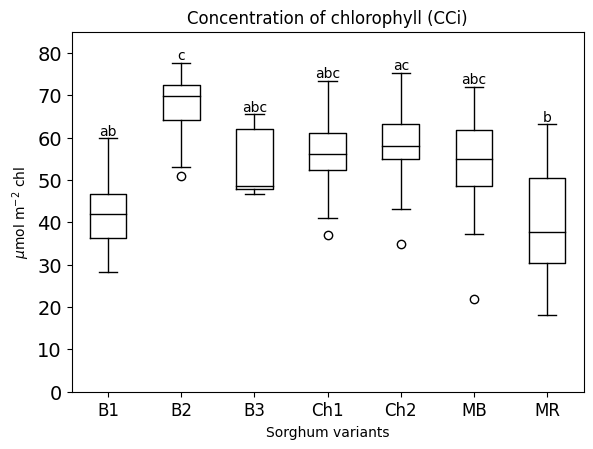

In [55]:

#Now to plot like R with a violing plot
fig,ax=plt.subplots()
data.boxplot(column=col_for_data, by=col_to_group,ax=ax,fontsize=14, color='black')

#,showmeans=True
#,boxprops=dict(linewidth=2.0),whiskerprops=dict(linewidth=2.0))  #This makes the boxplot

grps=pd.unique(data[col_to_group].values)   #Finds the group names
grps.sort() # This is critical!  Puts the groups in alphabeical order to make it match the plotting

#props=dict(facecolor='white',alpha=1)
''''''
for i,grp in enumerate(grps):   #I loop through the groups to make the scatters and figure out the axis labels.
    y_pos = data[data['Variant'] == grp]['Value'].max() + 3.4
    #y_pos = ax.get_ylim()[1]*1
    ax.text(i+1,y_pos,df_ltr.sum(axis=1)[i],rotation=0,fontsize=10,verticalalignment='top',horizontalalignment='center')

ax.set_xticklabels(grps,rotation=0,fontsize=12)
#ax.set_xticks()
ax.set_ylim([0, 85])
ax.set(title='Concentration of chlorophyll (CCi)', ylabel=r'$\mu$mol m$^{-2}$ chl', xlabel="Sorghum variants")
fig.suptitle('')

# PI $_{ABS}$ (performance index)
#

# CO$_2$ uptake (A$_{n}$)
# r'$\mu$mol m$^{-2}$s$^{-1}$ CO$_2$'

# Concentration of chlorophyll (CCi)
# $\mu$mol m$^{-2}$ chl

# TAC - water extracts
# mM AAE g${^-1}$

# PI $_{ABS}$
# (a.u.)

plt.grid(False)
#fig.savefig('anovatest.jpg',dpi=600,bbox_inches='tight')